The MedMNIST dataset contains several subsets. Each subset (e.g., pathmnist.npz) is comprised of 6 keys: <b>train_images, train_labels, val_images, val_labels, test_images and test_labels.</b>

<b><u>train_images / val_images / test_images:</u> N × 28 × 28 for 2D gray-scale datasets</b>, N × 28 × 28 × 3 for 2D RGB datasets, N × 28 × 28 × 28 for 3D datasets. <b>N denotes the number of samples.</b>
<br>
<br>
<b><u>train_labels / val_labels / test_labels:</u> N x L. N denotes the number of samples. L denotes the number of task labels; </b>for single-label (binary/multi-class) classification, L=1, and {0,1,2,3,..,C} denotes the category labels (C=1 for binary); <b>for multi-label classification L!=1, e.g., L=14 for chestmnist.npz.</b>

Data Modality: Chest X-ray
Task: Multi-Label (14) Binary-Class (2)
Number of Samples: 112,120 (Train: 78,468 / Test: 11,219 / Val: 22,433)
    
Source Data:
Xiaosong Wang, Yifan Peng, et al., "Chest x-ray8: Hospital-scale chest x-ray database and benchmarks on weakly-supervised classification and localization of common thorax diseases," in CVPR, 2017, pp. 3462–3471.

#### This is a Multi-Label Problem

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
data = np.load('chestmnist.npz')

In [28]:
help(data)

Help on NpzFile in module numpy.lib.npyio object:

class NpzFile(collections.abc.Mapping)
 |  NpzFile(fid, own_fid=False, allow_pickle=False, pickle_kwargs=None, *, max_header_size=10000)
 |  
 |  NpzFile(fid)
 |  
 |  A dictionary-like object with lazy-loading of files in the zipped
 |  archive provided on construction.
 |  
 |  `NpzFile` is used to load files in the NumPy ``.npz`` data archive
 |  format. It assumes that files in the archive have a ``.npy`` extension,
 |  other files are ignored.
 |  
 |  The arrays and file strings are lazily loaded on either
 |  getitem access using ``obj['key']`` or attribute lookup using
 |  ``obj.f.key``. A list of all files (without ``.npy`` extensions) can
 |  be obtained with ``obj.files`` and the ZipFile object itself using
 |  ``obj.zip``.
 |  
 |  Attributes
 |  ----------
 |  files : list of str
 |      List of all files in the archive with a ``.npy`` extension.
 |  zip : ZipFile instance
 |      The ZipFile object initialized with the zi

In [29]:
data.files

['train_images',
 'val_images',
 'test_images',
 'train_labels',
 'val_labels',
 'test_labels']

In [30]:
x_train = data['train_images']
x_test = data['test_images']
x_val = data['val_images']

y_train = data['train_labels']
y_test = data['test_labels']
y_val = data['val_labels']

In [31]:
print(x_train.shape, x_test.shape, x_val.shape, y_train.shape)

(78468, 28, 28) (22433, 28, 28) (11219, 28, 28) (78468, 14)


56


/opt/homebrew/Caskroom/miniconda/base/envs/CPU/lib/python3.8/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


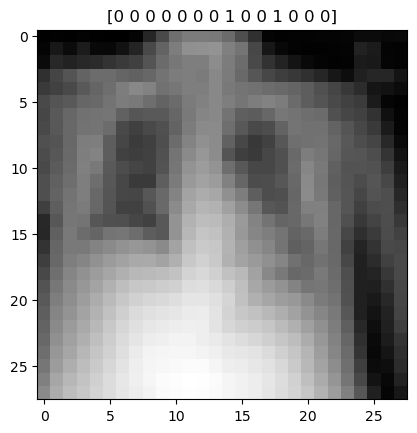

In [7]:
# Plotting

n = int(input())

plt.imshow(x_train[n], cmap='gray')
plt.title(y_train[n])
plt.show()

In [8]:
# Normalisation
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val = x_test / 255.0

# Flattening
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
x_val = x_val.reshape(-1, 28*28)

In [9]:
# [optional]
# Converting multi-label-based problem to binary-class-based problem

'''
y_train = (np.sum(y_train, axis=1) == 0).astype(int).reshape(-1, 1)
y_test = (np.sum(y_test, axis=1) == 0).astype(int).reshape(-1, 1)
y_val = (np.sum(y_val, axis=1) == 0).astype(int).reshape(-1, 1)

'''

# astype() to convert 'bool' to 'int'
# reshape() to change (n,) to (n, 1)

'\ny_train = (np.sum(y_train, axis=1) == 0).astype(int).reshape(-1, 1)\ny_test = (np.sum(y_test, axis=1) == 0).astype(int).reshape(-1, 1)\ny_val = (np.sum(y_val, axis=1) == 0).astype(int).reshape(-1, 1)\n\n'

In [10]:
# [optional] - To be used instead of 'softmax_stable()'

# Stable Sigmoid
def sigmoid(x, deriv=False):
    if deriv:
        s = sigmoid(x)
        return s * (1 - s)
    else:
        z = np.exp(-np.abs(x))
        return np.where(x > 0, 1 / (1 + z), z / (1 + z))
        # np.exp(x) / (1 + np.exp(x)) is a numerically stable version of sigmoid 

In [11]:
def relu(x, deriv=False):
    if deriv:
        return np.where(x <= 0, 0, 1) # TODO: Check if this should've been 'x < 0'. Is the value of ReLU '0' at '0' because 'x' is '0' or because it is inherently zero?
    else:
        return np.where(x <= 0, 0, x)
    
    '''
    if deriv:
        if x < 0: return 0 
        else: return 1
    else:
        if x < 0: return 0
        else: return x
    '''

# NOT IN USE
def softmax_stable(x, deriv=False):
    if deriv:
        s = softmax_stable(x)
        return s * (1 - s)
    else:
        temp = np.exp(x - np.max(x))
        return temp / np.sum(temp, axis=0)

In [24]:
class ChestNeuralNetwork:
    def __init__(self, input_size=784, hidden1_size=512, hidden2_size=256, hidden3_size=128, output_size=14):
        self.input_size = input_size # i
        self.hidden1_size = hidden1_size # H1
        self.hidden2_size = hidden2_size # H2
        self.hidden3_size = hidden3_size # H3
        self.output_size = output_size # o
        
        # TODO: Find what the sqrt does.
        
        # Weight initialisation
        self.W1 = np.random.randn(self.input_size, self.hidden1_size) / np.sqrt(self.input_size) # [i, H1]
        self.B1 = np.zeros((1, hidden1_size)) # [1, H1]
        
        self.W2 = np.random.randn(self.hidden1_size, self.hidden2_size) / np.sqrt(self.hidden1_size) # [H1, H2]
        self.B2 = np.zeros((1, hidden2_size)) # [1, H2]
        
        self.W3 = np.random.randn(self.hidden2_size, self.hidden3_size) / np.sqrt(self.hidden2_size) # [H2, H3]
        self.B3 = np.zeros((1, hidden3_size)) # [1, H3]
        
        self.W4 = np.random.randn(self.hidden3_size, self.output_size) / np.sqrt(self.hidden3_size) # [H3, o]
        self.B4 = np.zeros((1, self.output_size)) # [1, o]
        
    def forward_propagation(self, X):
        # A'n' = Activations at Layer 'n'
        self.A1 = relu(np.dot(X, self.W1) + self.B1) # [n, H1] = [n, i] x [i, H1]
        self.A2 = relu(np.dot(self.A1, self.W2) + self.B2) # [n, H2] = [n, H1] x [H1, H2]
        self.A3 = relu(np.dot(self.A2, self.W3) + self.B3) # [n, H3] = [n, H2] x [H2, H3]
        self.A4 = sigmoid(np.dot(self.A3, self.W4) + self.B4) # [n, o] = [n, H3] x [H3, o]
        
        return self.A4
        
    def backward_propagation(self, X, Y):
        self.error = self.A4 - Y # [n, o]
        
        # dA'n' = Error from Layer 'n'
        dA4 = self.error * sigmoid(self.A4, deriv=True)  # [n, o]

        dW4 = np.dot(self.A3.T, dA4) # [H3, o] = [n, H3].T x [n, o]
        dB4 = np.sum(dA4, axis=0, keepdims=True) # [1, o]
        
        dA3 = np.dot(dA4, self.W4.T) * relu(self.A3, deriv=True)  # [n, H3] = [n, o] x [H3, o].T * [n, H3]
        
        dW3 = np.dot(self.A2.T, dA3) # [H2, H3] = [n, H2].T x [n, H3]
        dB3 = np.sum(dA3, axis=0, keepdims=True) # [1, H3]
        
        dA2 = np.dot(dA3, self.W3.T) * relu(self.A2, deriv=True) # [n, H2] = [n, H3] x [H2, H3].T * [n, H2]
        
        dW2 = np.dot(self.A1.T, dA2) # [H1, H2] = [n, H1].T x [n, H2]
        dB2 = np.sum(dA2, axis=0, keepdims=True) # [1, H2]
        
        dA1 = np.dot(dA2, self.W2.T) * relu(self.A1, deriv=True) # [n, H1] = [n, H2] x [H1, H2].T * [n, H1]
        
        dW1 = np.dot(X.T, dA1) # [i, H1] = [n, i].T x [n, H1]
        dB1 = np.sum(dA1, axis=0, keepdims=True)
        
        return ((dW4, dW3, dW2, dW1), (dB4, dB3, dB2, dB1))
    
    def find_loss(self, Y, Ypred):
        Ypred = np.where(Ypred < 0.5, 0, 1) # Thresholding
            
        # Binary Crossentropy / Log Loss
        m = Y.shape[0]
        
        a = Y * np.log(Ypred + 1e-15) # Adding a small value to prevent log(0)
        b = (1 - Y) * np.log(1 - Ypred + 1e-15) # Adding a small value to prevent log(0)
        
        return - np.sum((a + b)) / m
    
    # def find_accuracy(self, Y, Ypred) is appropriate for Multi-class, & not Multi-label problem.
    
    def find_precision(self, Y, Ypred):
        Ypred = np.where(Ypred < 0.5, 0, 1) # Thresholding
        
        tp = np.sum(Y == Ypred) # True positive
        fp = np.sum(np.logical_and(Ypred == 1, Y == 0)) # False Positive
        
        return tp / (tp + fp) if (tp + fp) > 0 else 0
    
    def find_recall(self, Y, Ypred):
        Ypred = np.where(Ypred < 0.5, 0, 1) # Thresholding
        
        tp = np.sum(Y == Ypred) # True positive
        fn = np.sum(np.logical_and(Ypred == 0, Y == 1)) # False Negative
        
        return tp / (tp + fn) if (tp + fn) > 0 else 0
    
    def find_f1_score(self, Y, Ypred):
        precision = self.find_precision(Y, Ypred)
        recall = self.find_recall(Y, Ypred)
        
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
    def train_neural_network(self, X, Y, Xval, Yval, num_of_epochs, learning_rate):
        for epoch in range(num_of_epochs):
            # Implementing learning rate decay
            learning_rate = learning_rate / (1 + 0.001 * epoch)
            
            # Training
            A4 = self.forward_propagation(X)
            
            ((dW4, dW3, dW2, dW1), (dB4, dB3, dB2, dB1)) = self.backward_propagation(X, Y)
            
            # Update Weights & Biases
            self.W4 -= learning_rate * dW4
            self.B4 -= learning_rate * dB4
            
            self.W3 -= learning_rate * dW3
            self.B3 -= learning_rate * dB3
        
            self.W2 -= learning_rate * dW2
            self.B2 -= learning_rate * dB2
            
            self.W1 -= learning_rate * dW1
            self.B1 -= learning_rate * dB1
            
            loss = self.find_loss(Y, A4)
            
            # Validation
            A4val = self.forward_propagation(Xval)
            #f1_score = self.find_f1_score(Yval, A4val)
            f1_score = "placeholder"
            
            print(Y[5:10], self.A4[5:10])
            
            print(f"Epoch: {epoch} | Loss: {loss} | Validation F1: {f1_score}")

In [25]:
nn = ChestNeuralNetwork()
nn.train_neural_network(x_train, y_train, x_val, y_val, 3, 0.001)

[[0 0 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Epoch: 0 | Loss: 344.65225016825497 | Validation F1: YpurMom
[[0 0 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]] [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Epoch: 1 | Loss: 24.869257102416896 | Validation F1: YpurMom
[[0 0 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0